In [49]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from functions import *
from functions import plotting

(2115, 22, 1000)
(2115, 22, 1000)
(2115, 1000)


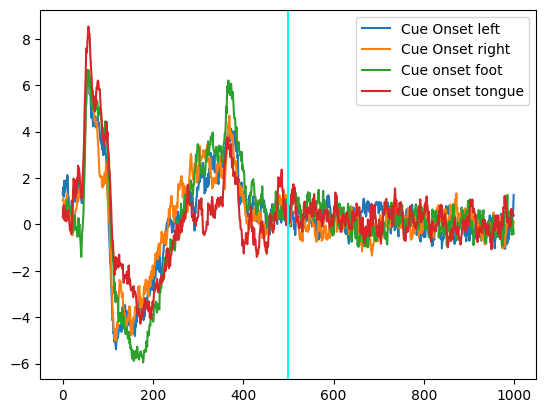

In [50]:
## Loading and visualizing the data

## Loading the dataset
X_test = np.load("../ECEC147project-data/X_test.npy")
y_test = np.load("../ECEC147project-data//y_test.npy")
person_train_valid = np.load("../ECEC147project-data//person_train_valid.npy")
X_train_valid = np.load("../ECEC147project-data/X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("../ECEC147project-data/y_train_valid.npy")
person_test = np.load("../ECEC147project-data/person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data
print(X_train_valid.shape)
ch_data = X_train_valid[:,8,:]
print(ch_data.shape)
class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)

plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

(237, 22, 1000)
(237,)
(50, 22, 1000)
(50,)
(1878, 22, 1000)
(1878,)


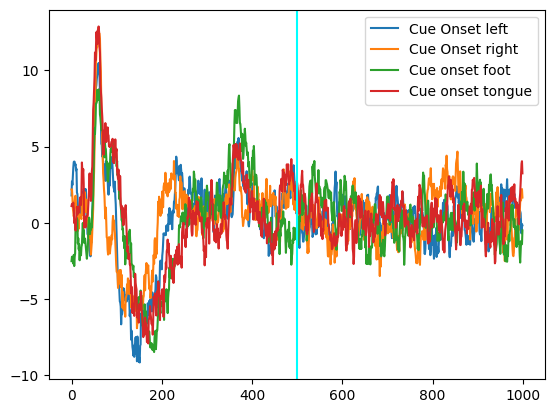

In [51]:
#Getting Data for Subject 1

subjectOne_train_valid_ind = np.where(person_train_valid == 0)
subjectOne_train_valid_ind = subjectOne_train_valid_ind[0]
subjectOne_X_train_valid = X_train_valid[subjectOne_train_valid_ind]
subjectOne_y_train_valid = y_train_valid[subjectOne_train_valid_ind]
subjectOne_test_ind = np.where(person_test == 0)
subjectOne_test_ind = subjectOne_test_ind[0]
subjectOne_X_test = X_test[subjectOne_test_ind]
subjectOne_y_test = y_test[subjectOne_test_ind]
print(np.shape(subjectOne_X_train_valid))
print(np.shape(subjectOne_y_train_valid))
print(np.shape(subjectOne_X_test))
print(np.shape(subjectOne_y_test))

#Subject 1 Train/Validation data:
#subjectOne_X_train_valid
#subjectOne_y_train_valid

#Subject 1 Test data:
#subjectOne_X_test
#subjectOne_y_test

rest_train_valid_ind = np.setdiff1d(np.arange(len(person_train_valid)), subjectOne_train_valid_ind)
rest_X_train_valid = X_train_valid[rest_train_valid_ind]
rest_y_train_valid = y_train_valid[rest_train_valid_ind]
print(np.shape(rest_X_train_valid))
print(np.shape(rest_y_train_valid))


ch_data = subjectOne_X_train_valid[:,8,:]
class_0_ind = np.where(subjectOne_y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(subjectOne_y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(subjectOne_y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(subjectOne_y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)

plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

In [52]:
def train_data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X):
    
    total_X = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)
    
    
    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)
    
    return total_X




# Question 1 Part 1

In [53]:
print(np.shape(subjectOne_X_train_valid))
print(np.shape(subjectOne_y_train_valid))
print(np.shape(subjectOne_X_test))
print(np.shape(subjectOne_y_test))

# Preprocessing test dataset
subjectOne_X_test_prep = test_data_prep(subjectOne_X_test) 

## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(len(subjectOne_X_train_valid), int(np.floor(len(subjectOne_X_train_valid)/6)), replace=False)
ind_train = np.array(list(set(range(len(subjectOne_X_train_valid))).difference(set(ind_valid))))

# First split then do preprocessing separately
# Creating the training and validation sets using the generated indices
(subjectOne_x_train_split, subjectOne_x_valid_split) = subjectOne_X_train_valid[ind_train], subjectOne_X_train_valid[ind_valid] 
(subjectOne_y_train_split, subjectOne_y_valid_split) = subjectOne_y_train_valid[ind_train], subjectOne_y_train_valid[ind_valid]

# Preprocessing the dataset after split to prevent leakage (augmentation and smoothing)
subjectOne_x_train,subjectOne_y_train = train_data_prep(subjectOne_x_train_split,subjectOne_y_train_split,2,2,True)
subjectOne_x_valid,subjectOne_y_valid = train_data_prep(subjectOne_x_valid_split,subjectOne_y_valid_split,2,2,True)

print('Shape of training set:',subjectOne_x_train.shape)
print('Shape of validation set:',subjectOne_x_valid.shape)
print('Shape of training labels:',subjectOne_y_train.shape)
print('Shape of validation labels:',subjectOne_y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
subjectOne_y_train = to_categorical(subjectOne_y_train, 4)
subjectOne_y_valid = to_categorical(subjectOne_y_valid, 4)
subjectOne_y_test = to_categorical(subjectOne_y_test, 4)
print('Shape of training labels after categorical conversion:',subjectOne_y_train.shape)
print('Shape of validation labels after categorical conversion:',subjectOne_y_valid.shape)
print('Shape of test labels after categorical conversion:',subjectOne_y_test.shape)

# Adding width of the segment to be 1
subjectOne_x_train = subjectOne_x_train.reshape(subjectOne_x_train.shape[0], subjectOne_x_train.shape[1], subjectOne_x_train.shape[2], 1)
subjectOne_x_valid = subjectOne_x_valid.reshape(subjectOne_x_valid.shape[0], subjectOne_x_valid.shape[1], subjectOne_x_train.shape[2], 1)
subjectOne_x_test = subjectOne_X_test_prep.reshape(subjectOne_X_test_prep.shape[0], subjectOne_X_test_prep.shape[1], subjectOne_X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',subjectOne_x_train.shape)
print('Shape of validation set after adding width info:',subjectOne_x_valid.shape)
print('Shape of test set after adding width info:',subjectOne_x_test.shape)


# Reshaping the training and validation dataset
subjectOne_x_train = np.swapaxes(subjectOne_x_train, 1,3)
subjectOne_x_train = np.swapaxes(subjectOne_x_train, 1,2)
subjectOne_x_valid = np.swapaxes(subjectOne_x_valid, 1,3)
subjectOne_x_valid = np.swapaxes(subjectOne_x_valid, 1,2)
subjectOne_x_test = np.swapaxes(subjectOne_x_test, 1,3)
subjectOne_x_test = np.swapaxes(subjectOne_x_test, 1,2)
print('Shape of training set after dimension reshaping:',subjectOne_x_train.shape)
print('Shape of validation set after dimension reshaping:',subjectOne_x_valid.shape)
print('Shape of test set after dimension reshaping:',subjectOne_x_test.shape)
print(np.shape(subjectOne_x_test))
print(np.shape(subjectOne_y_test))


(237, 22, 1000)
(237,)
(50, 22, 1000)
(50,)
Shape of X after trimming: (50, 22, 800)
Shape of X after maxpooling: (50, 22, 400)
Shape of X after trimming: (198, 22, 800)
Shape of X after maxpooling: (198, 22, 400)
Shape of X after averaging+noise and concatenating: (396, 22, 400)
Shape of X after subsampling and concatenating: (792, 22, 400)
Shape of Y: (792,)
Shape of X after trimming: (39, 22, 800)
Shape of X after maxpooling: (39, 22, 400)
Shape of X after averaging+noise and concatenating: (78, 22, 400)
Shape of X after subsampling and concatenating: (156, 22, 400)
Shape of Y: (156,)
Shape of training set: (792, 22, 400)
Shape of validation set: (156, 22, 400)
Shape of training labels: (792,)
Shape of validation labels: (156,)
Shape of training labels after categorical conversion: (792, 4)
Shape of validation labels after categorical conversion: (156, 4)
Shape of test labels after categorical conversion: (50, 4)
Shape of training set after adding width info: (792, 22, 400, 1)
Shape

In [54]:
# Model parameters
learning_rate = 1e-3
epochs = 100

Epoch 1/100
13/13 [==============================] - 4s 115ms/step - loss: 1.3773 - accuracy: 0.2740 - val_loss: 1.3994 - val_accuracy: 0.1538
Epoch 2/100
13/13 [==============================] - 1s 86ms/step - loss: 1.3439 - accuracy: 0.3106 - val_loss: 1.4058 - val_accuracy: 0.1538
Epoch 3/100
13/13 [==============================] - 1s 90ms/step - loss: 1.3167 - accuracy: 0.3497 - val_loss: 1.4137 - val_accuracy: 0.1538
Epoch 4/100
13/13 [==============================] - 1s 87ms/step - loss: 1.2639 - accuracy: 0.3990 - val_loss: 1.4274 - val_accuracy: 0.1538
Epoch 5/100
13/13 [==============================] - 1s 87ms/step - loss: 1.2080 - accuracy: 0.4192 - val_loss: 1.4315 - val_accuracy: 0.1603
Epoch 6/100
13/13 [==============================] - 1s 87ms/step - loss: 1.1331 - accuracy: 0.4596 - val_loss: 1.4858 - val_accuracy: 0.1603
Epoch 7/100
13/13 [==============================] - 1s 85ms/step - loss: 1.0612 - accuracy: 0.4798 - val_loss: 1.4006 - val_accuracy: 0.1987
Epoch

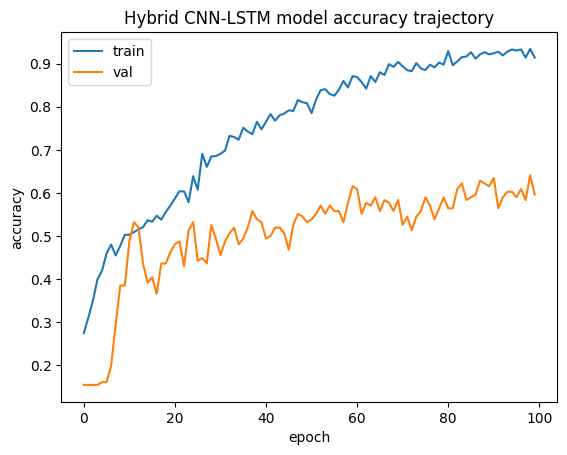

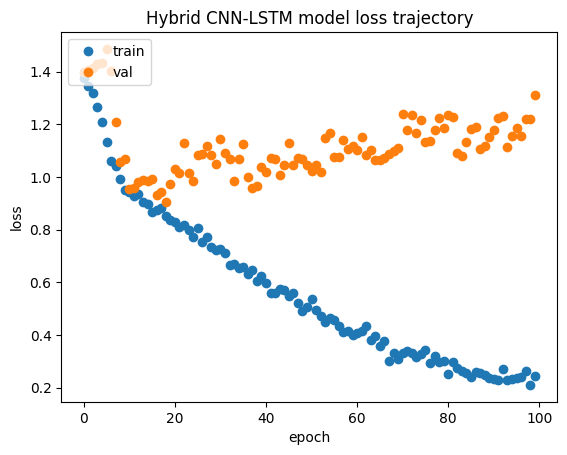

Test accuracy of the hybrid CNN-LSTM model: 0.5400000214576721


In [55]:
hybrid_cnn_lstm_model = hybrid()
# ADAM
# Compiling the model
hybrid_cnn_lstm_optimizer = keras.optimizers.Adam(lr=learning_rate)
hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(subjectOne_x_train,
             subjectOne_y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(subjectOne_x_valid, subjectOne_y_valid), verbose=True)

plotting(hybrid_cnn_lstm_model_results)


hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(subjectOne_x_test, subjectOne_y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])


# Question 1 Part 2

In [64]:
print(np.shape(rest_X_train_valid))
print(np.shape(rest_y_train_valid))

## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(len(rest_X_train_valid), int(np.floor(len(rest_X_train_valid)/6)), replace=False)
ind_train = np.array(list(set(range(len(rest_X_train_valid))).difference(set(ind_valid))))

# First split then do preprocessing separately
# Creating the training and validation sets using the generated indices
(rest_x_train_split, rest_x_valid_split) = rest_X_train_valid[ind_train], rest_X_train_valid[ind_valid] 
(rest_y_train_split, rest_y_valid_split) = rest_y_train_valid[ind_train], rest_y_train_valid[ind_valid]

# Preprocessing the dataset after split to prevent leakage (augmentation and smoothing)
rest_x_train,rest_y_train = train_data_prep(rest_x_train_split,rest_y_train_split,2,2,True)
rest_x_valid,rest_y_valid = train_data_prep(rest_x_valid_split,rest_y_valid_split,2,2,True)

print('Shape of training set:',rest_x_train.shape)
print('Shape of validation set:',rest_x_valid.shape)
print('Shape of training labels:',rest_y_train.shape)
print('Shape of validation labels:',rest_y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
rest_y_train = to_categorical(rest_y_train, 4)
rest_y_valid = to_categorical(rest_y_valid, 4)
print('Shape of training labels after categorical conversion:',rest_y_train.shape)
print('Shape of validation labels after categorical conversion:',rest_y_valid.shape)

# Adding width of the segment to be 1
rest_x_train = rest_x_train.reshape(rest_x_train.shape[0], rest_x_train.shape[1], rest_x_train.shape[2], 1)
rest_x_valid = rest_x_valid.reshape(rest_x_valid.shape[0], rest_x_valid.shape[1], rest_x_train.shape[2], 1)
print('Shape of training set after adding width info:',rest_x_train.shape)
print('Shape of validation set after adding width info:',rest_x_valid.shape)


# Reshaping the training and validation dataset
rest_x_train = np.swapaxes(rest_x_train, 1,3)
rest_x_train = np.swapaxes(rest_x_train, 1,2)
rest_x_valid = np.swapaxes(rest_x_valid, 1,3)
rest_x_valid = np.swapaxes(rest_x_valid, 1,2)
print('Shape of training set after dimension reshaping:',rest_x_train.shape)
print('Shape of validation set after dimension reshaping:',rest_x_valid.shape)


print(np.shape(rest_x_train))
print(np.shape(rest_x_valid))
print(np.shape(subjectOne_x_train))
print(np.shape(subjectOne_x_valid))

print(np.shape(rest_y_train))
print(np.shape(rest_y_valid))
print(np.shape(subjectOne_y_train))
print(np.shape(subjectOne_y_valid))
print(rest_y_train)
print(subjectOne_y_train)
combined_x_train = np.vstack([rest_x_train, subjectOne_x_train])
combined_x_valid = np.vstack([rest_x_valid, subjectOne_x_valid])
combined_y_train = np.vstack([rest_y_train, subjectOne_y_train])
combined_y_valid = np.vstack([rest_y_valid, subjectOne_y_valid])

print(np.shape(combined_x_train))
print(np.shape(combined_x_valid))
print(np.shape(combined_y_train))
print(np.shape(combined_y_valid))

(1878, 22, 1000)
(1878,)
Shape of X after trimming: (1565, 22, 800)
Shape of X after maxpooling: (1565, 22, 400)
Shape of X after averaging+noise and concatenating: (3130, 22, 400)
Shape of X after subsampling and concatenating: (6260, 22, 400)
Shape of Y: (6260,)
Shape of X after trimming: (313, 22, 800)
Shape of X after maxpooling: (313, 22, 400)
Shape of X after averaging+noise and concatenating: (626, 22, 400)
Shape of X after subsampling and concatenating: (1252, 22, 400)
Shape of Y: (1252,)
Shape of training set: (6260, 22, 400)
Shape of validation set: (1252, 22, 400)
Shape of training labels: (6260,)
Shape of validation labels: (1252,)
Shape of training labels after categorical conversion: (6260, 4)
Shape of validation labels after categorical conversion: (1252, 4)
Shape of training set after adding width info: (6260, 22, 400, 1)
Shape of validation set after adding width info: (1252, 22, 400, 1)
Shape of training set after dimension reshaping: (6260, 400, 1, 22)
Shape of valid

Epoch 1/100
111/111 [==============================] - 12s 91ms/step - loss: 1.3789 - accuracy: 0.2825 - val_loss: 1.3423 - val_accuracy: 0.3956
Epoch 2/100
111/111 [==============================] - 10s 91ms/step - loss: 1.3196 - accuracy: 0.3569 - val_loss: 1.3055 - val_accuracy: 0.3949
Epoch 3/100
111/111 [==============================] - 11s 96ms/step - loss: 1.2539 - accuracy: 0.4139 - val_loss: 1.2899 - val_accuracy: 0.3892
Epoch 4/100
111/111 [==============================] - 10s 92ms/step - loss: 1.2252 - accuracy: 0.4400 - val_loss: 1.2879 - val_accuracy: 0.4077
Epoch 5/100
111/111 [==============================] - 10s 93ms/step - loss: 1.1975 - accuracy: 0.4529 - val_loss: 1.2119 - val_accuracy: 0.4517
Epoch 6/100
111/111 [==============================] - 10s 92ms/step - loss: 1.1757 - accuracy: 0.4698 - val_loss: 1.2943 - val_accuracy: 0.3999
Epoch 7/100
111/111 [==============================] - 11s 99ms/step - loss: 1.1616 - accuracy: 0.4772 - val_loss: 1.2911 - val_ac

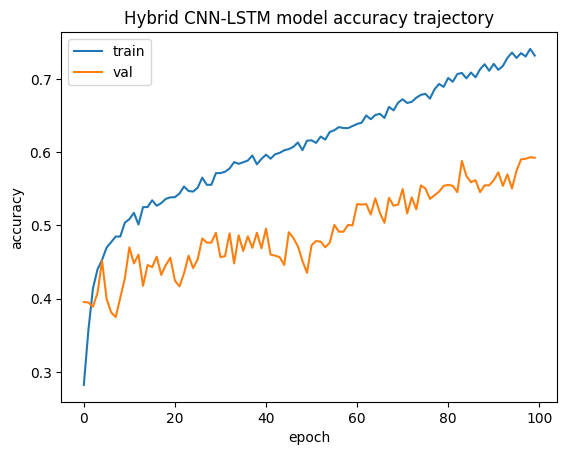

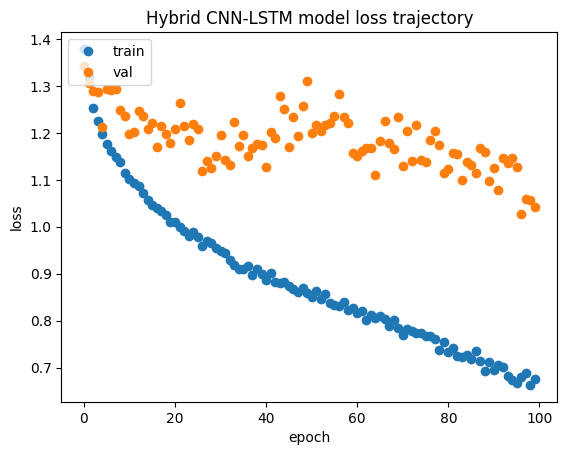

Test accuracy of the hybrid CNN-LSTM model: 0.6000000238418579


In [65]:
hybrid_cnn_lstm_model = hybrid()
# ADAM
# Compiling the model
hybrid_cnn_lstm_optimizer = keras.optimizers.Adam(lr=learning_rate)
hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(combined_x_train,
             combined_y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(combined_x_valid, combined_y_valid), verbose=True)

plotting(hybrid_cnn_lstm_model_results)


hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(subjectOne_x_test, subjectOne_y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])
